# Goal of Notebook:
### Create a Convelutional Neural Network(CNN) to classify arrythmias on Lead 1 EKG images.
### This CNN will be applied to classify heart rhythms of Apple Watch EKGs
** This notebook assumes a csv file and ekg lead 1 images have been created using notebooks
 - create_ecg_csv_extract_lead_1.ipynb [create_csv_notebook](https://github.com/bretttay24/ekg_applewatch/blob/main/notebooks/create_ecg_csv_extract_lead_1.ipynb)

 - create_ecg_image_dataset.ipynb [create_images_notebook](https://github.com/bretttay24/ekg_applewatch/blob/main/notebooks/create_ecg_image_dataset.ipynb)

**Process:**

**1) Explore the data on the created processed_ecg_data.csv**
- The original dataframe has 11 classes of heart rhythms, I will reduce it to 7 for training a CNN

**2) Create a way to filter out EKGs without desired labels in the image_dataset**

**3) Use Scikit-learn for splitting dataset of images and creating training/testing datasets**

**4) Create a tensorflow pipeline to preprocess .png files of the image_dataset and efficiently feed the CNN in training**

**5) Train CNN**

**6) Evaluate CNN performance**

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import re
import random
import PIL #Python Imaging Library
from glob import glob
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import display  # display images
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

2025-08-19 15:01:33.960468: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-19 15:01:34.302337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/brett_tay_12/workspace/.tf-env/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/brett_tay


## Pass the file path to the processed_ekg_data.csv 
**This was created from the notebook 'create_ecg_csv_extract_lead_1.ipynb'**

file_path = r'pass_your_own_file_paht_to/processed_ekg_data.csv'  # !! pass your own created path !!

In [2]:
file_path = r'datasets/processed_ecg_data.csv'  # !! pass your file path here !!
ecg_df = pd.read_csv(file_path)                                                                 # Creates ecg_df from reading csv file path
ecg_df.head()                                                                                   # View head of file

,file_name,rhythm,lead_1_data
0,MUSE_20180118_132508_86000,SB,"[28.56, 6.1529, -11.824, -22.725, -26.701, -25..."
1,MUSE_20180116_124640_27000,ST,"[7.7133, 3.4957, -1.6378, -7.7151, -13.76, -18..."
2,MUSE_20180113_171837_63000,SB,"[-10.816, -11.143, -11.407, -11.518, -11.336, ..."
3,MUSE_20180113_134112_95000,AFIB,"[-86.666, -82.155, -76.289, -68.804, -61.092, ..."
4,MUSE_20180118_135058_59000,SA,"[-68.682, -67.147, -64.614, -60.604, -55.135, ..."


### Evaluate ecg_df

In [3]:
ecg_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10645 entries, 0 to 10644
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_name    10645 non-null  object
 1   rhythm       10645 non-null  object
 2   lead_1_data  10645 non-null  object
dtypes: object(3)
memory usage: 249.6+ KB


In [4]:
ecg_df.tail(50)

,file_name,rhythm,lead_1_data
10595,MUSE_20180210_121056_29000,SR,"[8.4094, 4.5123, -1.6375, -10.577, -20.635, -2..."
10596,MUSE_20180118_123248_13000,SB,"[208.27, 207.85, 207.22, 206.23, 204.86, 203.1..."
10597,MUSE_20180112_121749_74000,AFIB,"[-12.099, -11.831, -11.549, -11.251, -10.945, ..."
10598,MUSE_20180118_134811_98000,AF,"[-57.333, -56.554, -55.123, -52.551, -48.656, ..."
10599,MUSE_20180114_065200_84000,AFIB,"[-354.85, -345.54, -337.12, -329.89, -323.98, ..."
10600,MUSE_20180209_123006_96000,SR,"[-7.0702, -7.8375, -7.6342, -5.9306, -2.8234, ..."
10601,MUSE_20180112_122850_57000,AF,"[-18.067, -25.015, -30.766, -34.16, -34.407, -..."
10602,MUSE_20180210_123904_76000,SR,"[41.088, 40.31, 38.468, 34.975, 29.959, 23.429..."
10603,MUSE_20180114_130152_75000,ST,"[11.978, 11.603, 11.284, 11.055, 10.927, 10.85..."
10604,MUSE_20180112_072928_89000,AFIB,"[-4.9786, -4.7891, -5.0336, -6.0823, -8.372, -..."


#### !!! On my first time running this the last 40 values were [0,0,0,0,0 etc]. I remove these and the rest of the notebook reflects this!!!

In [5]:
ekg_df = pd.DataFrame(ecg_df.iloc[:10605])  # Redefine ekg_df to not include the faulty ekgs that have values of [0,0,0,0,0, etc.]
ekg_df.tail()

,file_name,rhythm,lead_1_data
10600,MUSE_20180209_123006_96000,SR,"[-7.0702, -7.8375, -7.6342, -5.9306, -2.8234, ..."
10601,MUSE_20180112_122850_57000,AF,"[-18.067, -25.015, -30.766, -34.16, -34.407, -..."
10602,MUSE_20180210_123904_76000,SR,"[41.088, 40.31, 38.468, 34.975, 29.959, 23.429..."
10603,MUSE_20180114_130152_75000,ST,"[11.978, 11.603, 11.284, 11.055, 10.927, 10.85..."
10604,MUSE_20180112_072928_89000,AFIB,"[-4.9786, -4.7891, -5.0336, -6.0823, -8.372, -..."


In [6]:
unique_rhythms = ekg_df['rhythm'].value_counts() # Count the total of each rhythm label to see representation

In [7]:
unique_rhythms # View unique rhythms counts

rhythm
SB       3871
SR       1819
AFIB     1775
ST       1562
SVT       585
AF        445
SA        397
AT        121
AVNRT      16
AVRT        8
SAAWR       6
Name: count, dtype: int64

## Create df with filtered rhythm labels for CNN training

**Currently the dataset includes 11 different rhythm labels. I want to simplify this to 7 labels and remove the values of ['AT', 'AVNRT', 'AVRT', 'SAAWR']**

In [8]:
rhythms_to_remove = ['AT', 'AVNRT', 'AVRT', 'SAAWR']  # I do not want my CNN to learn these rhythms and will 
                                                      # create a new DataFrame that excludes rows with the specified rhythms

# Create new df with only rhythms I want to teach CNN to identify                                              
filtered_ekg_df = ekg_df[~ekg_df['rhythm'].isin(rhythms_to_remove)]


In [9]:
filtered_unique_rhythms = filtered_ekg_df['rhythm'].value_counts() # Create a count of representation of each of the 7 labels
filtered_unique_rhythms                                            # Verify counts and representations in dataframe

rhythm
SB      3871
SR      1819
AFIB    1775
ST      1562
SVT      585
AF       445
SA       397
Name: count, dtype: int64

In [10]:
filtered_ekg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10454 entries, 0 to 10604
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_name    10454 non-null  object
 1   rhythm       10454 non-null  object
 2   lead_1_data  10454 non-null  object
dtypes: object(3)
memory usage: 326.7+ KB


In [11]:
len(filtered_ekg_df)

10454

#### Above I used filtering to understand the data I was working with and representations. Below I will work with images in the 'datasets/ecg_images_NoColor' directory. These images have the file name and rhythm label combined.

# Extract label from each file name creating a df

### Create a function for extracting labels from file names

In [12]:
# Example filename
filename = "MUSE_20180111_155633_99000_rhythm_label_SVT.png"

def extract_label(filename):
    # Find the starting point of the label (after '_rhythm_label_')
    start_index = filename.find('_rhythm_label_')

    # Extract the part after '_rhythm_label_'
    label_and_extension = filename[start_index + len('_rhythm_label_'):]

    # Remove the '.png' extension
    label = label_and_extension.replace('.png', '')
    return label

# Test the function
label = extract_label(filename)
print(f"Extracted label: {label}") # Output: Extracted label: SVT

Extracted label: SVT


### Create list of image_paths and labels that will be used for the dataset training the CNN

In [13]:
# --- Define the set of rhythms to keep ---

allowed_labels = {'SB', 'SR', 'AFIB', 'ST', 'SVT', 'AF', 'SA'}

# apply to all files
image_dir = 'datasets/ecg_images_NoColor' # **CHANGE THIS TO YOUR ACTUAL IMAGE FOLDER PATH**
image_paths = []
labels = []

for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        full_path = os.path.join(image_dir, filename)
        extracted_label = extract_label(filename)
        
        # --- MODIFIED: Check if the label is valid AND in the allowed list ---
        if extracted_label and extracted_label in allowed_labels:
            image_paths.append(full_path)
            labels.append(extracted_label)

print(f"Total images found: {len(image_paths)}")
print(f"Total labels found: {len(labels)}")

# inspect the first few to verify
print("First 5 image paths:", image_paths[:5])
print("First 5 labels:", labels[:5])
print("last 5 lables", labels[-5:])

Total images found: 10452
Total labels found: 10452
First 5 image paths: ['datasets/ecg_images_NoColor/MUSE_20180113_124114_43000_rhythm_label_AFIB.png', 'datasets/ecg_images_NoColor/MUSE_20180114_132724_77000_rhythm_label_AFIB.png', 'datasets/ecg_images_NoColor/MUSE_20180114_070004_97000_rhythm_label_ST.png', 'datasets/ecg_images_NoColor/MUSE_20180113_073010_84000_rhythm_label_AFIB.png', 'datasets/ecg_images_NoColor/MUSE_20180118_175159_70000_rhythm_label_SB.png']
First 5 labels: ['AFIB', 'AFIB', 'ST', 'AFIB', 'SB']
last 5 lables ['SR', 'SVT', 'SB', 'ST', 'ST']


In [14]:
labels_unique = set(labels) # create a set of unique labels
labels_unique  # Verify that the labels are the 7 desired labels

{'AF', 'AFIB', 'SA', 'SB', 'SR', 'ST', 'SVT'}

### Create dataset with X being the path to images and y being the associated label

In [15]:
X_paths = np.array(image_paths)
y = np.array(labels)

### Use Scikit-learn to split data into training and testing.


In [16]:
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    X_paths, y, test_size=0.2, random_state=27, stratify=y       
)

In [17]:
print(f"Training images: {len(X_train_paths)}, Training labels: {len(y_train)}")
print(f"Testing images: {len(X_test_paths)}, Testing labels: {len(y_test)}")

# Check a sample to confirm
print("\nSample training data:")
for i in range(3):
    print(f"Image Path: {X_train_paths[i]}, Label: {y_train[i]}")

print("\nSample testing data:")
for i in range(3):
    print(f"Image Path: {X_test_paths[i]}, Label: {y_test[i]}")

Training images: 8361, Training labels: 8361
Testing images: 2091, Testing labels: 2091

Sample training data:
Image Path: datasets/ecg_images_NoColor/MUSE_20180118_175359_48000_rhythm_label_ST.png, Label: ST
Image Path: datasets/ecg_images_NoColor/MUSE_20180116_174909_70000_rhythm_label_AFIB.png, Label: AFIB
Image Path: datasets/ecg_images_NoColor/MUSE_20180114_134421_40000_rhythm_label_SB.png, Label: SB

Sample testing data:
Image Path: datasets/ecg_images_NoColor/MUSE_20180112_075324_37000_rhythm_label_SB.png, Label: SB
Image Path: datasets/ecg_images_NoColor/MUSE_20180113_183634_23000_rhythm_label_SB.png, Label: SB
Image Path: datasets/ecg_images_NoColor/MUSE_20180115_131612_92000_rhythm_label_SB.png, Label: SB


### Encode labels to convert from letters to numbers for CNN model

In [18]:

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to all unique labels and transform them to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)                    # Use transform, not fit_transform, for test set

# To see the mapping:
print("\nOriginal labels to encoded integers mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

print("\nSample encoded training labels:", y_train_encoded[:5])
print("Sample encoded testing labels:", y_test_encoded[:5])


Original labels to encoded integers mapping:
AF -> 0
AFIB -> 1
SA -> 2
SB -> 3
SR -> 4
ST -> 5
SVT -> 6

Sample encoded training labels: [5 1 3 3 3]
Sample encoded testing labels: [3 3 3 3 1]


### Create a tensorflow pipeline to preprocess .png files of the image_dataset and efficiently feed the CNN in training

In [19]:
# --- 1. Set up Constants and AUTOTUNE ---
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 512
num_classes=7

# --- 2. Create a Function to Load and Preprocess Images ---
# This function will be applied to every file path in your dataset.

def process_path(file_path, label):
  """
  This function loads and preprocesses images.
  It reads the file, and is sure all files have 3
  channels (RGB). It then resizes the image to fit
  into a 128 X 512 Convelutional Neural Network (CNN).
  It returns the resized image.
  """
  # Read the raw file from the path
  img = tf.io.read_file(file_path)
  # Decode it as a 3-channel (RGB) PNG image
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
  # Normalize pixel values to be between 0 and 1
  img = img / 255.0

  return img, label

# --- 3. Build the Training and Testing Datasets ---

# Create the training dataset from your file paths and encoded labels
train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train_encoded))
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache() # Cache the preprocessed images
train_ds = train_ds.shuffle(buffer_size=len(X_train_paths)) # Shuffle the data
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # Overlap data processing and model execution

# Create the testing dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test_encoded))
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.cache() # Cache for faster evaluation
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("Datasets created successfully!")
print("Training Dataset:", train_ds)
print("Testing Dataset:", test_ds)

Datasets created successfully!
Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


I0000 00:00:1755633700.113179   16000 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


#### Plot example of EKGs and labels

2025-08-19 15:01:46.567615: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


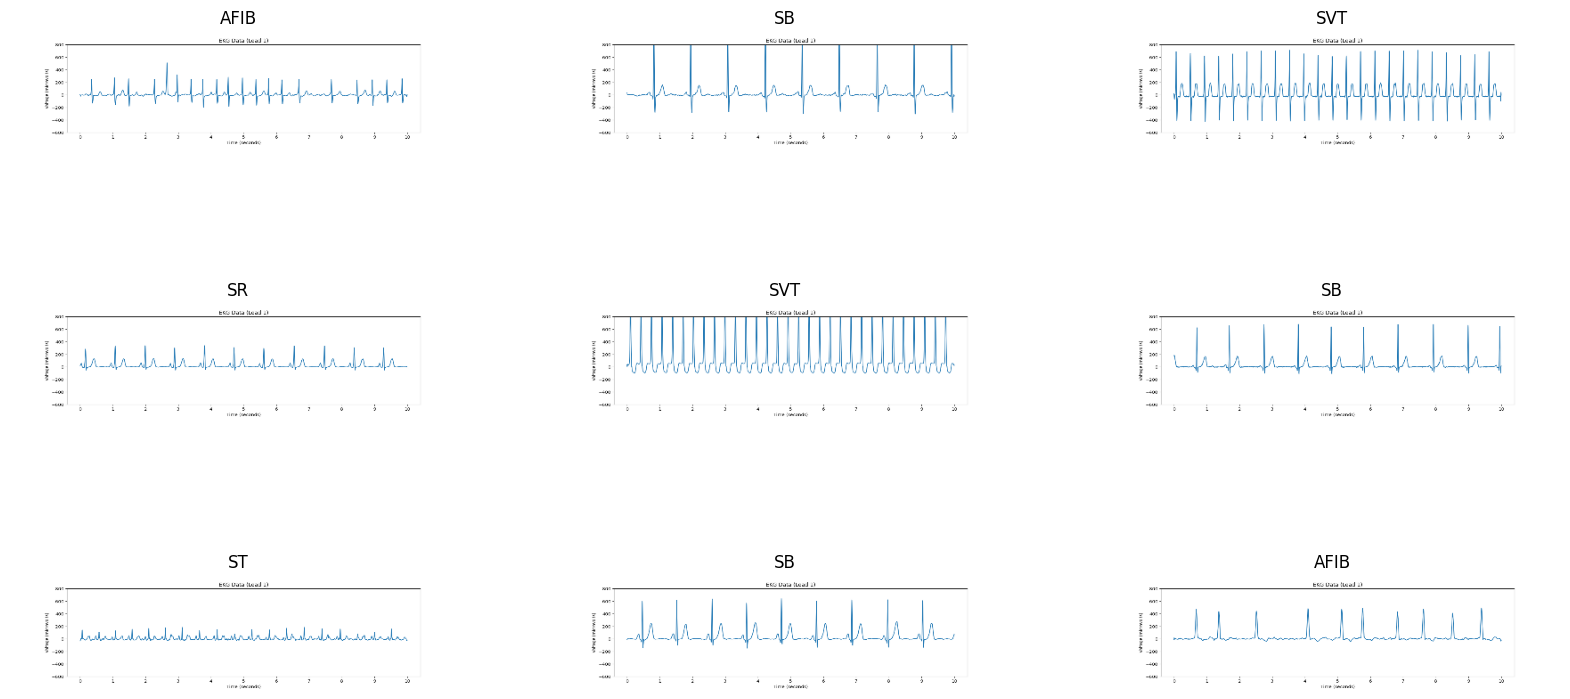

In [20]:
# To get the original string labels for plotting
class_names = label_encoder.classes_

plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1): # Take one batch
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()) # .numpy() converts the tensor to a numpy array
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

# CNN Model1

In [21]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the Sequential model
ekg_model = models.Sequential([
    # Input Layer
    layers.Input(shape=input_shape),

    # --- Feature Extraction Block ---

    # First Convolutional Block
    # 32 filters to learn basic features like edges and gradients.
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    # 64 filters to learn more complex patterns from the first block's features.
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    # 128 filters to learn even more abstract features.
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    # Dropout layer to help prevent overfitting.
    layers.Dropout(0.25),

    # --- Classifier Head ---

    # Flatten the 3D feature maps into a 1D vector.
    layers.Flatten(),

    # A dense layer to perform high-level reasoning.
    layers.Dense(512, activation='relu'),
    # Another dropout layer for regularization.
    layers.Dropout(0.5),

    # The final output layer.
    # It must have `num_classes` units and 'softmax' activation
    # for multi-class probability scores.
    layers.Dense(num_classes)
])

# Print the model's architecture
ekg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 256, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 256, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,206,215 (256.37 MB)

 Trainable params: 67,206,215 (256.37 MB)

 Non-trainable params: 0 (0.00 B)

## Train CNN and Save Best Model

In [22]:

ekg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # will use logits from final layer of CNN that did not have activation function applied
                      metrics=['accuracy']
                      )

# --- use early stopping ---
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 7, verbose=1)

# Create the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='EKG_CNN.keras',          # File path to save the model
    monitor='val_accuracy',            # The metric to monitor
    save_best_only=True,               # Only save a model if `val_accuracy` has improved
    mode='max',                        # `max` because we want to maximize the metric
    verbose=1                          # Print a message when a model is saved
)



# --- Set seed to reproduce results ---
tf.random.set_seed(27)

epochs = 50
# --- fit/train ---
history = ekg_model.fit(train_ds, epochs=epochs,
                           validation_data=test_ds,
                           callbacks=[callback, model_checkpoint], verbose=1)

Epoch 1/50


2025-08-19 15:01:48.325014: I external/local_xla/xla/service/service.cc:163] XLA service 0x7d5e1801ed20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-19 15:01:48.325044: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-08-19 15:01:48.348696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-19 15:01:48.519044: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-19 15:01:49.241442: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_955', 60 bytes spill stores, 60 bytes spill loads

2025-08-19 15:01:51.197573: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (G

  2/262 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.2422 - loss: 2.1819

I0000 00:00:1755633716.251020   16193 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.3606 - loss: 1.7903

2025-08-19 15:02:29.301422: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1027', 12 bytes spill stores, 24 bytes spill loads

2025-08-19 15:02:31.046532: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-19 15:02:34.344522: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3608 - loss: 1.7896

2025-08-19 15:02:40.131865: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-19 15:02:44.638402: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 4 bytes spill stores, 4 bytes spill loads

2025-08-19 15:02:46.541414: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_accuracy improved from None to 0.44859, saving model to EKG_CNN.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 62s 203ms/step - accuracy: 0.4095 - loss: 1.6169 - val_accuracy: 0.4486 - val_loss: 1.3915
Epoch 2/50
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4869 - loss: 1.3769
Epoch 2: val_accuracy improved from 0.44859 to 0.57293, saving model to EKG_CNN.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - accuracy: 0.5143 - loss: 1.3350 - val_accuracy: 0.5729 - val_loss: 1.2047
Epoch 3/50
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5465 - loss: 1.2392
Epoch 3: val_accuracy improved from 0.57293 to 0.61549, saving model to EKG_CNN.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.5652 - loss: 1.2030 - val_accuracy: 0.6155 - val_loss: 1.1055
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6002 - loss: 1.1366
Epoch 4: val_accuracy improved from 0.61549 to 0.66523, saving model to EKG_CNN.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 35s 135

## Evaluate CNN

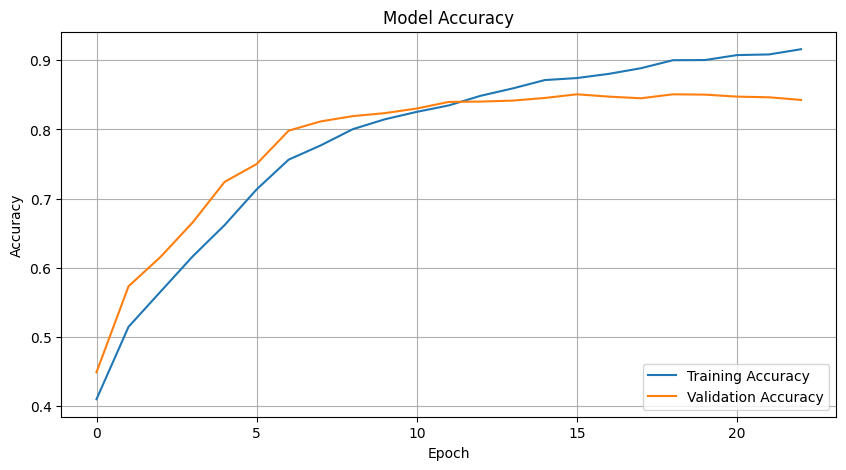

In [23]:
# Create a new figure for the accuracy plot
plt.figure(figsize=(10, 5))

# Plot accuracy directly from the history object
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Add titles and labels
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Display the plot
plt.grid(True)
plt.show()

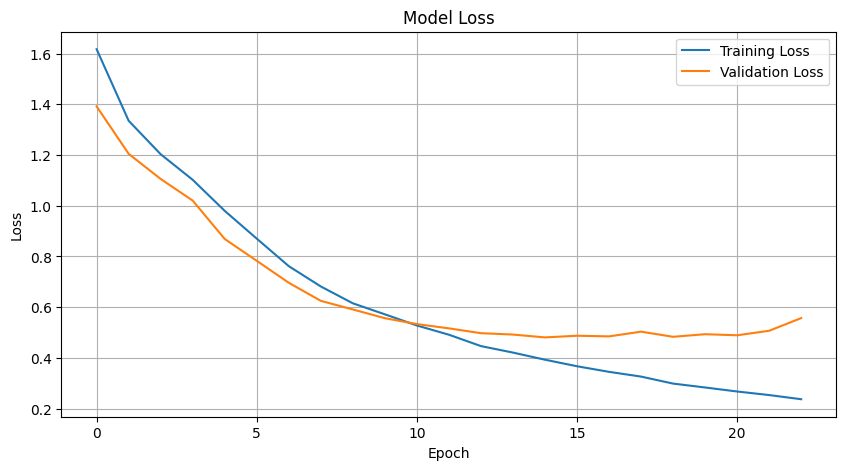

In [24]:

# Create a new figure for the loss plot
plt.figure(figsize=(10, 5))

# Plot loss directly from the history object
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add titles and labels
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plot
plt.grid(True)
plt.show()

### Evaluate best CNN Predictions using confusion matrix , precision, recall

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

Using labels: [np.str_('AF'), np.str_('AFIB'), np.str_('SA'), np.str_('SB'), np.str_('SR'), np.str_('ST'), np.str_('SVT')]

Classification Report
              precision    recall  f1-score   support

          AF       0.60      0.07      0.12        89
        AFIB       0.75      0.86      0.80       356
          SA       0.54      0.09      0.15        80
          SB       0.96      0.98      0.97       778
          SR       0.83      0.89      0.86       365
          ST       0.79      0.91      0.84       314
         SVT       0.74      0.78      0.76       109

    accuracy                           0.85      2091
   macro avg       0.74      0.65      0.64      2091
weighted avg       0.83      0.85      0.83      2091


Confusion Matrix


2025-08-19 15:18:18.069986: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


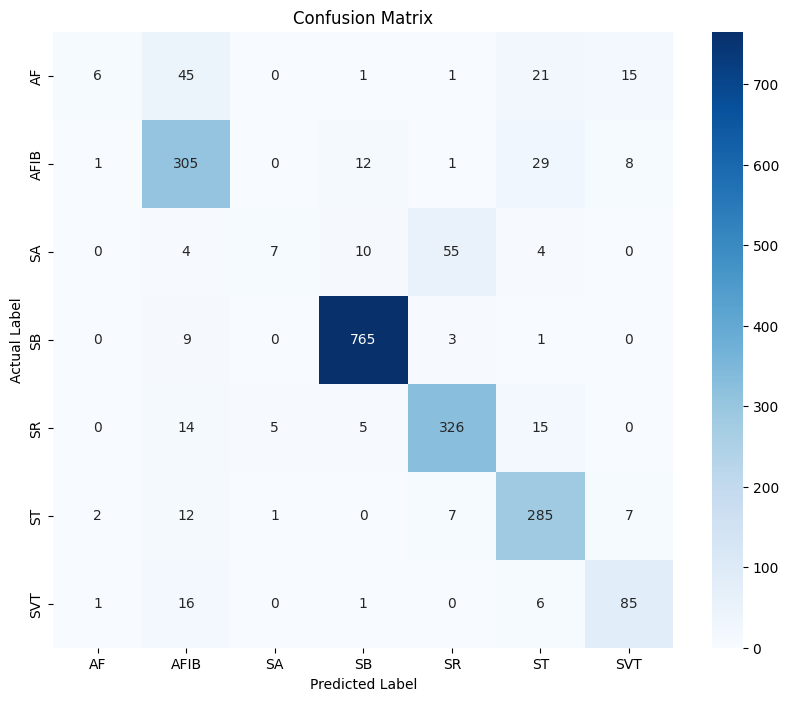

In [25]:

# --- 1. Load the Best Saved Model ---
best_model = tf.keras.models.load_model('EKG_CNN.keras')


# --- 2. Make Predictions and Get True Labels  ---
# Instead of iterating, predict on the entire dataset at once for a significant speed-up.
y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract the true labels directly from the dataset object.
y_true = np.concatenate([y for x, y in test_ds], axis=0)


# --- 3. Define Label Mapping  ---
# Get class names directly from the fitted LabelEncoder.

label_names = label_encoder.classes_
print(f"\nUsing labels: {list(label_names)}")

# --- 4. Generate Classification Report ---
print("\n" + "="*60)
print("Classification Report")
print("="*60)
print(classification_report(y_true, y_pred, target_names=label_names))

# --- 5. Generate and Plot the Confusion Matrix ---
print("\n" + "="*60)
print("Confusion Matrix")
print("="*60)
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()